# Which Hard Drives are Most Reliable? 

## Plan


The goal of our project is to determine which hard drives are most reliable by classifying and predicting early hard drive failures. 

Hypotheses:
- The 5 SMART (Self-Monitoring, Analysis and Reporting Technology) stats identified by Backblaze will indicate device hard drive failure
- Hard drive fail rates will vary by model 
- Hard drives fail rates will vary by manufacturer 

In [1]:
# data wrangling
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# py files
import acquire
import prepare
import explore
import model

# data modeling
from sklearn.metrics import classification_report, confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Acquire

The raw data is available on Backblaze.com. For this analysis, the hard drive data from 2016 - 2019 is utilized. The files are downloaded to a local computer and then unzipped. The files are renamed to the format, "data_Qx_201x", and placed in a folder titled "data". 

The `acquire.acquire_agg_data` function reads in the data, aggregates it, and returns a Pandas dataframe. 
- Using Spark, a dataframe is created from each directory of csv files. The dataframes are concated together with their common columns. This gives a dataframe with 95 columns and 121,390,247 rows. 
- Backblaze identifies 5 SMART stats that predict hard drive failure (SMART 5, 187, 188, 197, 198). The max value of each of these stats are extracted and the dataframe is aggregated by serial number. This reduces the dataframe to 9 columns and 169,073 rows. 
- The spark dataframe is converted to a Pandas dataframe 
- The Pandas dataframe is saved as "hard_drives_smart_5.csv" for future use

This csv is linked in the README and can be downloaded. If "hard_drives_smart_5.csv" is in the working directory, `acquire.acquire_agg_data` will read from the csv instead recreating the dataframe.  

In [2]:
df = acquire.acquire_agg_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169073 entries, 0 to 169072
Data columns (total 10 columns):
serial_number         169072 non-null object
model                 169073 non-null object
capacity_bytes        169073 non-null int64
max(failure)          169073 non-null int64
max(smart_9_raw)      161975 non-null float64
max(smart_5_raw)      161851 non-null float64
max(smart_187_raw)    104189 non-null float64
max(smart_188_raw)    104179 non-null float64
max(smart_197_raw)    161841 non-null float64
max(smart_198_raw)    161841 non-null float64
dtypes: float64(6), int64(2), object(2)
memory usage: 12.9+ MB


In [4]:
df.head()

,serial_number,model,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
0,PL1311LAG1SJAA,Hitachi HDS5C4040ALE630,4000787030016,0,43819.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,ST4000DM000,4000787030016,0,31045.0,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi HDS5C3030ALA630,3000592982016,0,41668.0,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,ST8000DM002,8001563222016,0,26284.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi HDS5C3030ALA630,3000592982016,0,47994.0,0.0,NaN,NaN,0.0,0.0


In [5]:
df.describe()

,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
count,1.690730e+05,169073.000000,161975.000000,161851.000000,104189.000000,1.041790e+05,161841.000000,161841.000000
mean,6.829480e+12,0.035085,23858.714839,69.851802,5.996190,3.264823e+08,6.265940,5.913261
std,3.981103e+12,0.183996,13357.230448,1393.236993,541.364663,3.014661e+10,452.148242,447.550251
min,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,4.000787e+12,0.000000,13727.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,4.000787e+12,0.000000,22932.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,1.200014e+13,0.000000,34866.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
max,1.400052e+13,1.000000,90477.000000,65392.000000,65535.000000,8.933668e+12,142616.000000,142616.000000


## Prepare

The `prepare.prepare` function reads in the dataframe and applies the following changes:
- Converts capacity column from bytes to terabytes.
- Converts max(smart_9_raw) from hours to years.
- Creates a new column for manufacturer name.
- Renames all columns appropriately.
- Reorders columns for understandability. 

In [6]:
df = prepare.prepare(df)

In [7]:
df.head()

,serial_number,manufacturer,model,capacity_terabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
0,PL1311LAG1SJAA,Hitachi,Hitachi HDS5C4040ALE630,4.0,0,5.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,Seagate,ST4000DM000,4.0,0,3.5,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi,Hitachi HDS5C3030ALA630,3.0,0,4.8,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,Seagate,ST8000DM002,8.0,0,3.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi,Hitachi HDS5C3030ALA630,3.0,0,5.5,0.0,NaN,NaN,0.0,0.0


In [8]:
df.capacity_terabytes.value_counts()

 4.0     64886
 12.0    50729
 8.0     26108
-0.0      7031
 3.0      6789
 2.0      4678
 0.5      2607
 6.0      2411
 14.0     1302
 10.0     1255
 1.0       388
 0.3       327
 1.5       267
 0.2       210
 5.0        46
 0.1        39
Name: capacity_terabytes, dtype: int64

> Due to aggregation, we have 7,031 duplicate hard drives listed with zero capacity bytes. 

The `prepare.unique` function reads in the dataframe and removes duplicated serial numbers that were created during aggregation.

In [9]:
df = prepare.unique(df)

In [10]:
# Confirm duplicate hard drives with zero capacity have been removed
df.capacity_terabytes.value_counts()

4.0     64878
12.0    50729
8.0     26106
3.0      6789
2.0      4678
0.5      2607
6.0      2411
14.0     1302
10.0     1255
1.0       388
0.3       327
1.5       267
0.2       210
5.0        46
0.1        32
Name: capacity_terabytes, dtype: int64

## Explore

Questions to answer:
- How do we treat null values?
- What does our data look like?
    - How many different models?
    - How many different manufacturers?
    - How many different capacity sizes?
    - How many models are there for each manufacturer?
    - Are model numbers unique to capacity?
    - Are there any observations that need to be dropped (why, how many)?
- What is a failure?
    - What do failures look like?
    - How is this misleading?
    - How do we define an early failure?
- How do the lifespans of hard drives that have failed compared to hard drives that have not failed?
- How do non-zero SMART stat values compare to among fail and non-fail?
- Does the average age of drive vary by manufacturer? model number?
- Do failure rates vary by model number?
- Determine early failure cutoff by analyzing data.
- Which SMART attributes correlate most strongly with early failure? 
- Which features or combination of features correlate with early failure?

### How do we treat null values?

In [11]:
# Check for null values
df.isnull().sum()

serial_number                        1
manufacturer                         0
model                                0
capacity_terabytes                   0
failure                              0
drive_age_in_years                  60
reallocated_sectors_count          184
reported_uncorrectable_errors    57839
command_timeout                  57849
current_pending_sector_count       194
uncorrectable_sector_count         194
dtype: int64

In [12]:
df.columns

Index(['serial_number', 'manufacturer', 'model', 'capacity_terabytes',
       'failure', 'drive_age_in_years', 'reallocated_sectors_count',
       'reported_uncorrectable_errors', 'command_timeout',
       'current_pending_sector_count', 'uncorrectable_sector_count'],
      dtype='object')

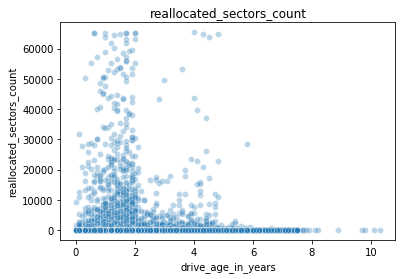

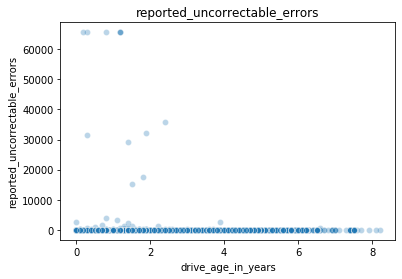

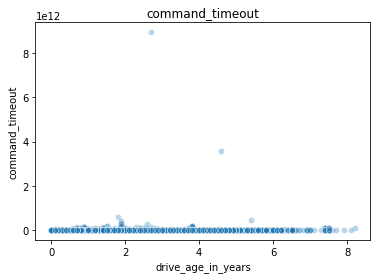

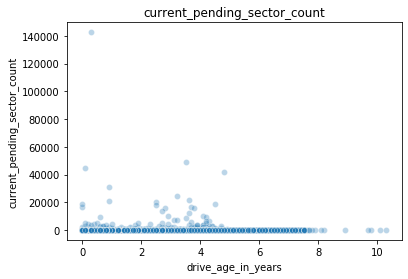

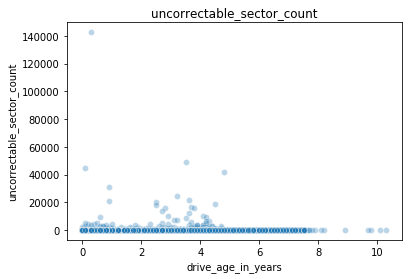

In [13]:
# Create scatterplot for SMART attributes
for col in df.columns[6:]:
    sns.scatterplot(data=df, y=df[col], x=df.drive_age_in_years, alpha=.3)
    plt.title(col)
    plt.show()

> For both "reported_uncorrectable_errors" and "command_timeout" the vast majority of values are zero. Therefore, the nulls in these columns are replaced with zeros. For the remaining nulls in "reallocated_sectors_count", "current_pending_sector_count" and "uncorrecteable_sector_count", there are less than 200 for each respective column. Therefore, those rows containing nulls are removed. This is performed in the `prepare.treat_nulls` function.

In [14]:
df = prepare.treat_nulls(df)

In [15]:
# Confirm all nulls have been removed 
df.isnull().sum()

serial_number                    0
manufacturer                     0
model                            0
capacity_terabytes               0
failure                          0
drive_age_in_years               0
reallocated_sectors_count        0
reported_uncorrectable_errors    0
command_timeout                  0
current_pending_sector_count     0
uncorrectable_sector_count       0
dtype: int64

In [16]:
df.shape

(161830, 11)

> After treating all nulls, the dataframe has 11 columns and 161,830 rows. The data can be further explored. 

### What does our data look like?

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161830 entries, 0 to 169067
Data columns (total 11 columns):
serial_number                    161830 non-null object
manufacturer                     161830 non-null object
model                            161830 non-null object
capacity_terabytes               161830 non-null float64
failure                          161830 non-null int64
drive_age_in_years               161830 non-null float64
reallocated_sectors_count        161830 non-null float64
reported_uncorrectable_errors    161830 non-null float64
command_timeout                  161830 non-null float64
current_pending_sector_count     161830 non-null float64
uncorrectable_sector_count       161830 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 14.8+ MB


#### How many different hard drive models in our dataset? Which are the 5 most popular?

> 97 unique hard drive models. Top 5 hard drive models include 3 Seagate and 2 Hitachi.

In [18]:
df.model.nunique()

97

In [19]:
df['model'].value_counts().head()

ST12000NM0007           38271
ST4000DM000             36156
HGST HMS5C4040BLE640    16314
ST8000NM0055            14810
HGST HUH721212ALN604    10875
Name: model, dtype: int64

#### How many different manufacturers are included in our data set?

> 6 unique manufacturers exist: Hitachi, Seagate, Western Digital, Toshiba, Unknown, and Samsung.

In [20]:
df.manufacturer.nunique()

6

In [21]:
df.manufacturer.unique()

array(['Hitachi', 'Seagate', 'Western Digital', 'Toshiba', 'Unknown',
       'Samsung'], dtype=object)

#### How many different capacity sizes exist for the hard drives in our dataset?

> 15 unique hard drive capacity sizes after rounding to the nearest tenth of a terabyte.

In [22]:
df.capacity_terabytes.nunique()

15

In [23]:
df.capacity_terabytes.unique()

array([ 4. ,  3. ,  8. ,  0.5,  6. ,  2. ,  1. ,  0.1, 12. , 10. , 14. ,
        1.5,  0.2,  0.3,  5. ])

#### How many hard drives exist for each manufacturer?

> Seagate and Hitachi are the most popular manufacturers. Samsung and Unknown only have 1 hard drive each. These hard drives should be dropped from our dataset. 

In [24]:
df[['model', 'manufacturer']].groupby('manufacturer').count()

,model
manufacturer,
Hitachi,51417
Samsung,1
Seagate,105012
Toshiba,2573
Unknown,1
Western Digital,2826


#### Remove Samsung and Unknown hard drives

The `explore.remove_manufacturer` function reads in the dataframe and removes the two manufacturers with low value counts.

In [25]:
df = explore.remove_manufacturers(df)

In [26]:
# Confirm low count manufacturers have been removed
df[['model', 'manufacturer']].groupby('manufacturer').count()

,model
manufacturer,
Hitachi,51417
Seagate,105012
Toshiba,2573
Western Digital,2826


#### Are model numbers unique to capacity?

> Yes, model numbers are unique to capacity. We ask this question to ensure there are not any hard drive models that have different capacities. 

In [27]:
# create new df to group models with their capacity terabytes
model_terabytes = df[['model', 'capacity_terabytes']]

In [28]:
# count unique models
model_terabytes.model.nunique()

95

In [29]:
# group unique model and unique terabytes combinations
unique_model_terabytes = len(model_terabytes.groupby(['model', 'capacity_terabytes']).count())

In [30]:
# compare the length of unique model and gigabytes combinations to the count of unique models, must equal a match.
unique_model_terabytes == model_terabytes.model.nunique()

True

#### Does the average hard drive age vary by manufacturer? By model?

In [31]:
# Average drive age by manufacturer
manufacturers = df[['manufacturer', 'drive_age_in_years']].groupby('manufacturer',sort=True).mean()
manufacturers

,drive_age_in_years
manufacturer,
Hitachi,3.057432
Seagate,2.557938
Toshiba,1.611698
Western Digital,3.765322


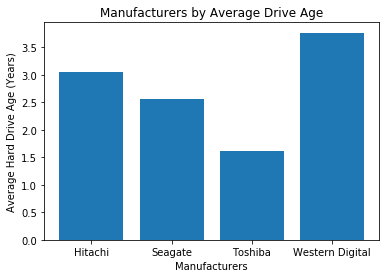

In [32]:
# Plot of Manufacturers by Average Drive Age
ax1 = plt.bar(x= manufacturers.index ,height=manufacturers.drive_age_in_years)
plt.xlabel('Manufacturers')
plt.ylabel('Average Hard Drive Age (Years)')
plt.title('Manufacturers by Average Drive Age')
plt.show()

In [33]:
# Drive age aggregated by model number and sorted. Top 10 models returned
model_avg_age = df[['model', 'drive_age_in_years']].groupby('model',sort=True).mean().sort_values('drive_age_in_years', ascending = False)
model_avg_age.head()

,drive_age_in_years
model,
WDC WD800LB,10.300000
WDC WD800BB,9.240000
Hitachi HDT725025VLA380,7.800000
WDC WD3200AAKS,6.800000
WDC WD10EACS,6.586667


Text(0.5, 1.0, 'Models by Average Drive Age')

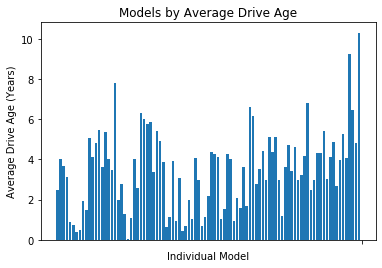

In [34]:
# Plot of Models by Average Drive Age
mod = model_avg_age.groupby('model').mean()
ax2 = plt.bar(x= mod.index ,height=mod.drive_age_in_years)
plt.xticks('')
plt.xlabel('Individual Model')
plt.ylabel('Average Drive Age (Years)')
plt.title('Models by Average Drive Age')

> Variance in drive age is seen in both the manufacturers and model numbers. The variance is more apparent amoung hard drive models.

### What is a hard drive failure?

According to Backblaze, a hard drive failure occurs when a drive stops spinning, won’t stay as a member of a RAID array, or demonstrates continuous degradation over time as informed by SMART stats and other system checks.

Because we aggregate the failure column by the max value, a "0" signifies a hard drive that has yet to fail, and a "1" signifies a hard drive that has failed. 

#### What do failures look like? 

In [35]:
df.failure.value_counts()

0    155917
1      5911
Name: failure, dtype: int64

In [36]:
(df.failure == 1).sum() / len(df)

0.03652643547470154

> Only 3.7% of all hard drives have been recorded as "failed"

#### How do the lifespans of hard drives that have failed compared to hard drives that have not failed?

In [37]:
# create new dfs with hard drives that have failed, and hard drives that have not failed 
df_fails = df [df.failure == 1]
df_lives = df [df.failure == 0]

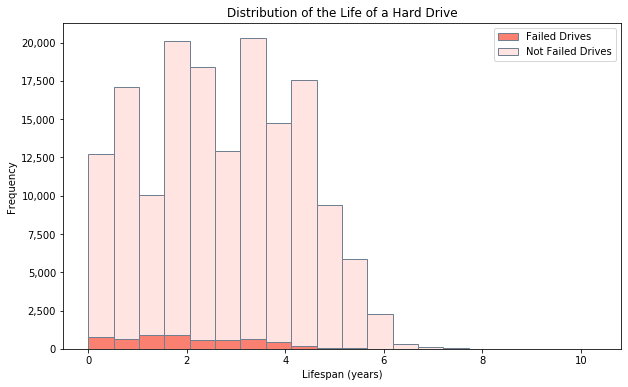

In [38]:
plt.figure(figsize=(10,6))
plt.hist([df_fails.drive_age_in_years, df_lives.drive_age_in_years], stacked=True, bins=20,
         edgecolor='slategrey', color=['salmon', 'mistyrose'])
plt.legend(["Failed Drives","Not Failed Drives"])
plt.title("Distribution of the Life of a Hard Drive")
plt.xlabel("Lifespan (years)")
plt.ylabel("Frequency")
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))             
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

#### How is this misleading?
- Failures include not only drives that have failed, but also drives that have yet to fail but show signs of failing soon. Our goal is to determine the reliability of hard drives. Therefore, it is acceptable to classify imminently failing drives as failures. 
- Failures do not take into account the lifespan of the hard drive. It is important to realize that all hard drives, given enough time, will eventually fail. For example, a typical lifespan of a hard drive is 5 years. If a hard drive fails after 10 years of continual operation, then it should have a reliable rating, as it lasted well past it's typical lifespan. Therefore, the focus will be on drives that fail before reaching their average lifespan. 

> We will identify hard drives that are more prone to early failures.  

#### How do we define an early failure? 

The goal of the project is to determine which hard drives are more prone to early failures. Looking at the lifespan of all hard drives, a hard drive that fails within the half of all life spans, is labeled as an early failure.

In [39]:
df[['drive_age_in_years']].describe()

,drive_age_in_years
count,161828.000000
mean,2.722680
std,1.524778
min,0.000000
25%,1.600000
50%,2.600000
75%,4.000000
max,10.300000


> A cut-off age of 2.6 years is utilized for early failure.

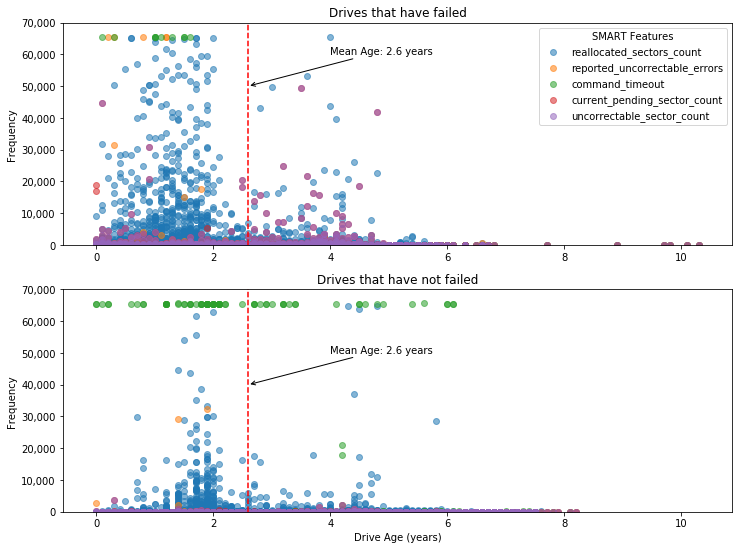

In [40]:
fig = plt.figure(figsize=(12,9))

ax1 = plt.subplot(2, 1, 1)

for col in df.columns[6:]:
    plt.scatter(y=df_fails[col], x=df_fails.drive_age_in_years, label=col, alpha = .55)
plt.legend(title = 'SMART Features')
plt.vlines(2.6, 0, 70_000, linestyles= "dashed", colors = 'red')
plt.ylim((0, 70_000))
plt.ylabel("Frequency")
plt.title('Drives that have failed')
ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))             

plt.annotate(
    f'Mean Age: 2.6 years',
    xy=(2.6, 50_000),
    xytext=(4, 60_000),
    arrowprops={'arrowstyle': '->'})

ax2 = plt.subplot(2, 1, 2, sharex=ax1)

for col in df.columns[6:]:
    plt.scatter(y=df_lives[col], x=df_lives.drive_age_in_years, label=col, alpha = .55)
plt.vlines(2.6, 0, 70_000, linestyles='dashed',colors = 'red')
plt.ylim((0, 70_000))
plt.xlabel("Drive Age (years)")
plt.ylabel("Frequency")
plt.title("Drives that have not failed")
ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))  

plt.annotate(
    'Mean Age: 2.6 years',
    xy=(2.6, 40_000),
    xytext=(4, 50_000),
    arrowprops={'arrowstyle': '->'})
plt.show()


The `explore.early_failure` function creates a column in the dataframe that identifies drives that are early failures.

In [41]:
df = explore.early_failure(df)

#### Removing young non-failing hard drives

Hard drives that are currently functioning properly, but have yet reached the established cut-off age will be removed from this analysis. These hard drives have not been powered on long enough to give significant stats of a reliable drive. The `explore.old_or_fail` function drops rows containing drives that have not failed and are not older than the cut off age (2.6 years).

In [42]:
df = explore.old_or_fail(df)

In [43]:
df.shape

(83940, 12)

> After defining early failures and removing young non-failing drives, the dataframe has 12 columns and 83,940 rows. The data can be further explored. 

#### How many of the hard drives are identified as early failures?

In [44]:
df.early_failure.value_counts()

0    79954
1     3986
Name: early_failure, dtype: int64

In [45]:
(df.early_failure == 1).sum() / len(df)

0.04748629973790803

> Only 4.7% of hard drives are identified as early failures after the removal of young non-failing drives.

#### Do early failure rates vary by model number?

In [46]:
# aggegrate by early failure, drive age, and add a total count
agg_model = df.groupby(['manufacturer','model']).agg({'early_failure' : 'sum', 'model' : 'count', 'drive_age_in_years':'mean'})
agg_model.rename(columns={'early_failure':'early_failures', 'model':'total_drives', 'drive_age_in_years':'average_age_in_years'}, inplace=True)

# add an early failure rate column
agg_model['early_failure_rate_percent'] = agg_model['early_failures'] / agg_model['total_drives'] * 100
agg_model.sort_values('early_failures', ascending = False)

early_failures  total_drives  \
manufacturer    model                                                   
Seagate         ST4000DM000                        1498         34901   
                ST12000NM0007                      1104          1104   
                ST8000NM0055                        383           442   
                ST8000DM002                         276          9928   
Hitachi         HGST HMS5C4040BLE640                197         10920   
Toshiba         TOSHIBA MQ01ABF050                  112           249   
Hitachi         HGST HMS5C4040ALE640                 59          7673   
Seagate         ST500LM012 HN                        41           603   
                ST4000DM001                          34            34   
Western Digital WDC WD30EFRX                         34           814   
Seagate         ST6000DX000                          29          1890   
Western Digital WDC WD60EFRX                         29           465   
Seagate         ST500LM030                           28            28   
Hitachi         HGST HUH721212ALN604                 25            25   
Toshiba         TOSHIBA MQ01ABF050M                  19            19   
Seagate         ST10000NM0086                        14            14   
                ST320LT007                           14            73   
Hitachi         HGST HUH728080ALE600                 12            57   
Toshiba         TOSHIBA MG07ACA14TA                  11            11   
Western Digital WDC WD5000LPVX                        7           332   
                WDC WD20EFRX                          6             6   
Seagate         ST4000DM005                           5             5   
                ST12000NM0117                         5             5   
                ST4000DX002                           4             4   
Hitachi         HGST HUH721212ALE600                  4             4   
Seagate         ST8000DM004                           4             4   
                ST9250315AS                           3            56   
Hitachi         HGST HUS726040ALE610                  3             3   
Western Digital WDC WD5000LPCX                        3            50   
Seagate         ST8000DM005                           2             2   
...                                                 ...           ...   
Western Digital WDC WD5003ABYX                        0             1   
Hitachi         Hitachi HDS5C3030ALA630               0          4540   
Western Digital WDC WD800AAJB                         0             7   
                WDC WD800AAJS                         0            14   
                WDC WD800BB                           0             5   
                WDC WD800JB                           0             4   
                WDC WD800JD                           0             1   
                WDC WD2500BPVT                        0             8   
                WDC WD2500BEVT                        0             1   
                WDC WD2500AAJS                        0             3   
                WDC WD10EADS                          0           287   
Seagate         ST3500320AS                           0             1   
                ST33000651AS                          0             1   
                ST3160318AS                           0            47   
                ST3160316AS                           0            53   
                ST31500541AS                          0           264   
                ST31500341AS                          0             1   
Western Digital WDC WD1000FYPS                        0             1   
                WDC WD10EACS                          0            60   
                WDC WD10EADX                          0             9   
                WDC WD2500AAJB                        0             1   
                WDC WD10EALS                          0             1   
                WDC WD10EA

In [49]:
agg_model.index.value_counts()

(Toshiba, TOSHIBA DT01ACA300)         1
(Western Digital, WDC WD1600BPVT)     1
(Seagate, ST4000DM000)                1
(Seagate, ST9250315AS)                1
(Hitachi, HGST HUH721212ALN604)       1
(Seagate, ST3160318AS)                1
(Western Digital, WDC WD3200BEKT)     1
(Seagate, ST250LT007)                 1
(Seagate, ST500LM030)                 1
(Seagate, ST8000DM004)                1
(Hitachi, Hitachi HDS723030BLE640)    1
(Western Digital, WDC WD1000FYPS)     1
(Western Digital, WDC WD800JB)        1
(Hitachi, Hitachi HDS723020BLA642)    1
(Western Digital, WDC WD800BB)        1
(Seagate, ST8000DM002)                1
(Hitachi, HGST HMS5C4040BLE640)       1
(Western Digital, WDC WD800AAJS)      1
(Western Digital, WDC WD40EFRX)       1
(Western Digital, WDC WD800JD)        1
(Hitachi, Hitachi HDS723030ALA640)    1
(Toshiba, TOSHIBA MG07ACA14TA)        1
(Seagate, ST8000NM0055)               1
(Western Digital, WDC WD2500BPVT)     1
(Hitachi, Hitachi HDS5C4040ALE630)    1


In [46]:
# aggegrate by early failure, drive age, and add a total count
agg_model = df.groupby(['model']).agg({'early_failure' : 'sum', 'model' : 'count', 'drive_age_in_years':'mean'})
agg_model.rename(columns={'early_failure':'early_failures', 'model':'total_drives', 'drive_age_in_years':'average_age_in_years'}, inplace=True)

# add an early failure rate column
agg_model['early_failure_rate_percent'] = agg_model['early_failures'] / agg_model['total_drives'] * 100
agg_model.sort_values('early_failures', ascending = False)

,early_failures,total_drives,average_age_in_years,early_failure_rate_percent
model,,,,
ST4000DM000,1498,34901,3.947474,4.292141
ST12000NM0007,1104,1104,1.046830,100.000000
ST8000NM0055,383,442,1.395249,86.651584
ST8000DM002,276,9928,3.018433,2.780016
HGST HMS5C4040BLE640,197,10920,3.511181,1.804029
TOSHIBA MQ01ABF050,112,249,2.259839,44.979920
HGST HMS5C4040ALE640,59,7673,3.842408,0.768930
ST500LM012 HN,41,603,3.475456,6.799337
ST4000DM001,34,34,0.244118,100.000000


> When aggregating by model number, we see wide variance in hard drive age and early failure rates. 

#### Which SMART attributes correlate most strongly with early failure?

The five SMART stats being presented count the occurrence of different types of errors that can occur in hard drives. For each type a count of above zero indicates that a hard drive should be replaced quickly due to a risk of failure.

In [47]:
smart_stats_5 = df.columns[6:11]
smart_stats_5

Index(['reallocated_sectors_count', 'reported_uncorrectable_errors',
       'command_timeout', 'current_pending_sector_count',
       'uncorrectable_sector_count'],
      dtype='object')

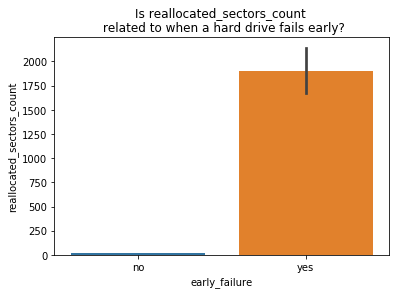

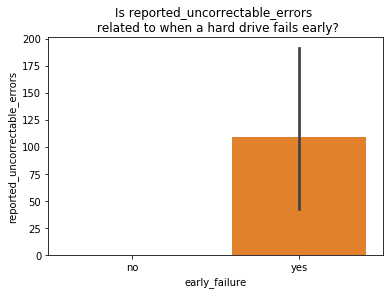

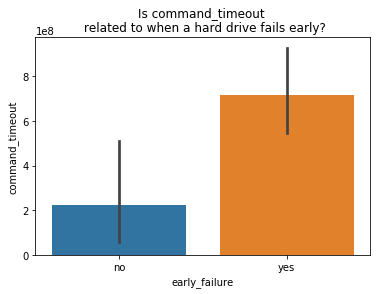

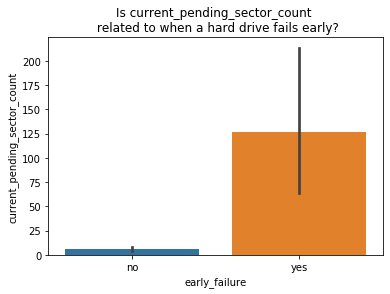

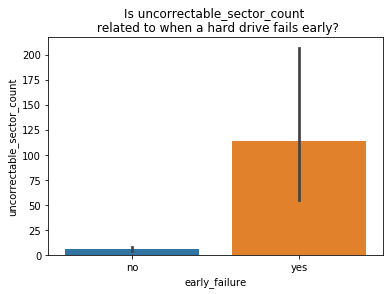

In [48]:
for stat in smart_stats_5:
    sns.barplot(df.early_failure,df[stat])
    plt.title("Is {} \n related to when a hard drive fails early?".format(stat))
    plt.xticks([0,1],["no","yes"])
    plt.show()

> Because these errors occur far more frequently in early failures than in non-early failures, all of these SMART seem to be a good indicator for early failures. 

#### Which manufacturer produces the most early failures?

In [49]:
pd.crosstab(df.manufacturer, df.early_failure)

early_failure,0,1
manufacturer,,
Hitachi,31138,305
Seagate,46247,3451
Toshiba,374,146
Western Digital,2195,84


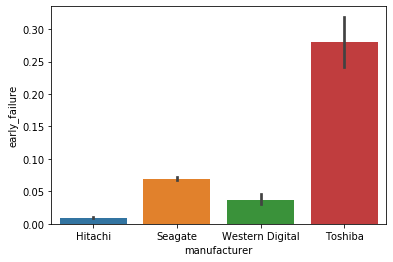

In [50]:
sns.barplot(df.manufacturer,df.early_failure)
plt.show()

> Of the four manufacturers being analyzed, Toshiba produces significantly more early failures.

#### Does drive capacity size correlate with early failure rates? 

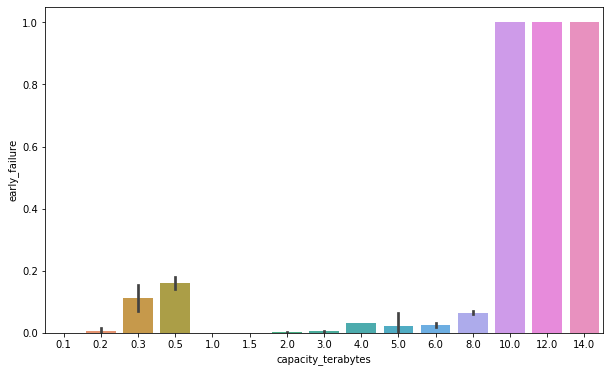

In [51]:
# sns.set(rc={'figure.figsize':(10,6)})
plt.figure(figsize=(10,6))
sns.barplot(df.capacity_terabytes,df.early_failure)
plt.show()

> Early failure rate dramatically increases in drives that have a 10 - 14 terabytes capacity.

#### How do SMART stat values compare in early failed drives?

In [52]:
smart_stats_5

Index(['reallocated_sectors_count', 'reported_uncorrectable_errors',
       'command_timeout', 'current_pending_sector_count',
       'uncorrectable_sector_count'],
      dtype='object')

The five SMART stats utilized in this analysis are all counters:
- reallocated_sectors_count: counts the sectors that have been found and revamped
- reported_uncorrectable_errors: counts the errors that couldnt be recovered using hardware
- command_timeout: counts the aborted operations due to timeout
- current_pending_sector_count: counts the number of unstable sectors
- uncorrectable_sector_count: counts the uncorrectable errors when reading/writing sector

In [53]:
df.groupby('early_failure').sum()[smart_stats_5]

,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
early_failure,,,,,
0,1508120.0,19489.0,1.771718e+13,494078.0,490643.0
1,7587344.0,434002.0,2.860500e+12,504772.0,453491.0


When any of these SMART stats are anything other than zero, this is a bad sign for the hard drive, regardless of the counter. Therefore, the `explore.make_binary_values` function will look at these columns, and if any contain a value greater than zero, it is replaced with a boolean True or False. This simplies the columns visuals, and will also make it simplier to feed into our model. 

In [54]:
# Make features binary
df = explore.make_binary_values(df)

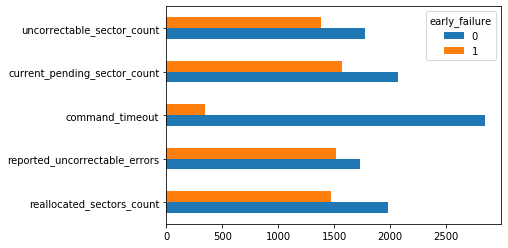

In [55]:
df.groupby('early_failure').sum()[smart_stats_5].T.plot.barh()
plt.show()

>Even though the non-early-failure hard drives have more SMART stats triggered in each column, it must be noted that the only 4.7% of all hard drives are early failures. 

#### Does the hard drive model affect the early failure rate?

The `explore.chi2_models` function determines if a model is independent of the early fail rate by using a chi squared test. 
> H0: the hard drive model is independent of early failure rate

In [56]:
df_stat = explore.chi2_models(df)
df_stat

,model,chi2,p,signif
0,Hitachi HDS5C4040ALE630,132.6020,0.0000,True
1,ST4000DM000,27.3500,0.0000,True
2,Hitachi HDS5C3030ALA630,238.1687,0.0000,True
3,ST8000DM002,95.9810,0.0000,True
4,HGST HMS5C4040BLE640,239.8896,0.0000,True
5,ST500LM012 HN,5.1995,0.0226,True
6,ST6000DX000,43.4400,0.0000,True
7,HGST HMS5C4040ALE640,294.7374,0.0000,True
8,WDC WD5000BPKT,0.3770,0.5392,False
9,Hitachi HDS722020ALA330,230.5352,0.0000,True


> The models that have True in the 'signif' column have failed to reject the null hypothesis. Therefore, it cannot be said that these models are independent of early failure rates. 

In [57]:
len (df_stat [df_stat.signif == True])

54

In [58]:
# create a list of all the signif models
stat_sig_models = list(df_stat [df_stat.signif == True].model)

In [59]:
df.model [df.model.isin(stat_sig_models)].value_counts()

ST4000DM000                34901
HGST HMS5C4040BLE640       10920
ST8000DM002                 9928
HGST HMS5C4040ALE640        7673
Hitachi HDS5C3030ALA630     4540
Hitachi HDS722020ALA330     4482
Hitachi HDS5C4040ALE630     2639
ST6000DX000                 1890
ST12000NM0007               1104
Hitachi HDS723030ALA640      995
ST500LM012 HN                603
ST8000NM0055                 442
WDC WD5000LPVX               332
WDC WD10EADS                 287
ST31500541AS                 264
TOSHIBA MQ01ABF050           249
ST4000DX000                  173
TOSHIBA MD04ABA400V          147
WDC WD1600AAJS               100
ST320LT007                    73
HGST HUH728080ALE600          57
ST4000DM001                   34
ST500LM030                    28
HGST HUH721212ALN604          25
TOSHIBA MQ01ABF050M           19
ST10000NM0086                 14
TOSHIBA MG07ACA14TA           11
WDC WD20EFRX                   6
ST4000DM005                    5
ST12000NM0117                  5
HGST HUH72

In [60]:
len(df.model.value_counts() [df.model.value_counts() > 10])

44

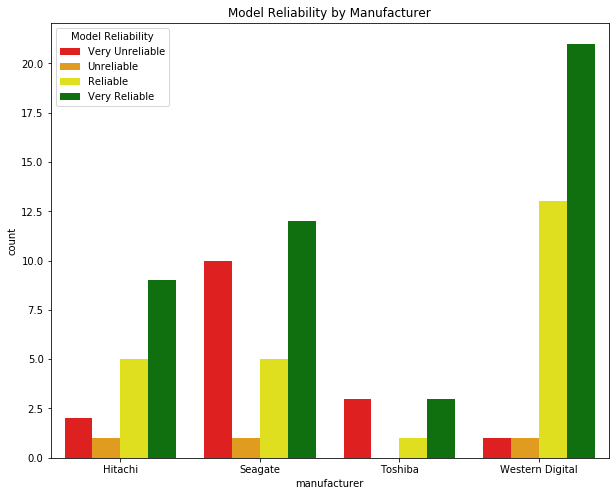

In [61]:
#models by quartile by manufacturer
explore.get_manufacturer_graph(df)

## Split

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83940 entries, 0 to 168960
Data columns (total 12 columns):
serial_number                    83940 non-null object
manufacturer                     83940 non-null object
model                            83940 non-null object
capacity_terabytes               83940 non-null float64
failure                          83940 non-null int64
drive_age_in_years               83940 non-null float64
reallocated_sectors_count        83940 non-null bool
reported_uncorrectable_errors    83940 non-null bool
command_timeout                  83940 non-null bool
current_pending_sector_count     83940 non-null bool
uncorrectable_sector_count       83940 non-null bool
early_failure                    83940 non-null int64
dtypes: bool(5), float64(2), int64(2), object(3)
memory usage: 8.0+ MB


The `model.split_my_data` function takes the dataframe and first splits by features and target. 
- For the features dataframe (X), the following columns are removed: 'failure', 'early_faliure', and 'drive_age_in_years'
- For the target dataframe (y), only the 'early_failure' column is retained

Next, the function splits each dataframe (X and y) into a train and test. 
- The train size is set as 80% 
- A random state is set at 123
- The early_failure is stratified, to ensure an even split between train and test

In [63]:
X_train, X_test, y_train, y_test = model.split_my_data(df)

In [64]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((67152, 7), (16788, 7), (67152, 1), (16788, 1))

In [65]:
X_train.head()

,manufacturer,capacity_terabytes,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
121424,Seagate,12.0,True,False,False,True,True
51821,Seagate,4.0,False,False,False,False,False
39076,Hitachi,4.0,False,False,False,False,False
139516,Hitachi,4.0,False,False,False,False,False
50771,Hitachi,4.0,False,False,False,False,False


The `model.encode_hot` function is used to one hot encode the manufacturer column and removes the original column.

In [66]:
# One hot encode manufacturer column
X_train, X_test = model.encode_hot(X_train, X_test, 'manufacturer')

In [67]:
X_train.head()

,capacity_terabytes,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count,Hitachi,Seagate,Toshiba,Western Digital
121424,12.0,True,False,False,True,True,0.0,1.0,0.0,0.0
51821,4.0,False,False,False,False,False,0.0,1.0,0.0,0.0
39076,4.0,False,False,False,False,False,1.0,0.0,0.0,0.0
139516,4.0,False,False,False,False,False,1.0,0.0,0.0,0.0
50771,4.0,False,False,False,False,False,1.0,0.0,0.0,0.0


## Model 

The training dataset is prepared for the model selection phase in order to best predict the dependent early failure variable. There are ten attributes in the train dataset for modeling and they include the capacity terabytes, the 5 SMART stats, and the binary encoded 4 manufacters. 

This is a binary classification problem and we will use Support Vector Machine, K-Nearest Neighbor, Logistic Regression, and Decision Tree algorithms to solve this problem. The rest of the section consists of standard machine learning steps.

The 4 modeling functions: `svc_model`, `knn_model`, `logit_model`, `dt_model` perform the following 2 steps for training the algorithm and making predictions.

1. Training the algorithm - the fit method of the classifier is called to train the algorithm on the training data, which is passed as a parameter to the fit method.


2. Making predictions - to make predictions, the predict method of the classifier is used.

The `model.evaluate` function will return evaluation metrics in the following way.

1. Evaluating the algorithm - Scikit-Learn's metrics library contains the classification_report and confusion_matrix methods, which can be readily used to find out the values for these important metrics.

### Support Vector Machine

- The Support Vector Machine classifier with the hyperparameters: kernal = 'rbf', class_weight = 'balanced', random_state = 123

In [68]:
y_pred_svc, y_pred_test_svc = model.svc_model(X_train, y_train, X_test)

In [69]:
model.evaluate(y_train, y_pred_svc)

[[60289  3674]
 [  765  2424]]

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     63963
           1       0.40      0.76      0.52      3189

    accuracy                           0.93     67152
   macro avg       0.69      0.85      0.74     67152
weighted avg       0.96      0.93      0.94     67152



### K-Nearest Neighbor

- The K-Nearest Neighbor classifier with the hyperparameters: n_neighbors = 3, weights = 'distance'

In [70]:
y_pred_knn, y_pred_test_knn = model.knn_model(X_train, y_train, X_test)

In [71]:
model.evaluate(y_train, y_pred_knn)

[[63526   437]
 [ 1715  1474]]

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     63963
           1       0.77      0.46      0.58      3189

    accuracy                           0.97     67152
   macro avg       0.87      0.73      0.78     67152
weighted avg       0.96      0.97      0.96     67152



### Logistic Regression

- the Logistic Regression classifier with the hyperparamaters: solver = 'liblinear', class_weight = 'balanced', random_state = 123

In [72]:
y_pred_logit, y_pred_test_logit = model.logit_model(X_train, y_train, X_test)

In [73]:
model.evaluate(y_train, y_pred_logit)

[[53370 10593]
 [  647  2542]]

              precision    recall  f1-score   support

           0       0.99      0.83      0.90     63963
           1       0.19      0.80      0.31      3189

    accuracy                           0.83     67152
   macro avg       0.59      0.82      0.61     67152
weighted avg       0.95      0.83      0.88     67152



### Decision Tree

- The Random Forest classifier with the hyperparameters: criterion = 'entropy', class_weight = 'balanced', max_depth = 6, random_state = 123

In [74]:
y_pred_dt, y_pred_test_dt = model.dt_model(X_train,y_train, X_test)

In [75]:
model.evaluate(y_train, y_pred_dt)

[[60327  3636]
 [  791  2398]]

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     63963
           1       0.40      0.75      0.52      3189

    accuracy                           0.93     67152
   macro avg       0.69      0.85      0.74     67152
weighted avg       0.96      0.93      0.94     67152



#### Analysis: 

The Support Vector Machine and Decision Tree models had the best combination of Accuracy, Recall, and Macro Average metrics. Also the 2 models selected to pass test data in the next section had the lowest False Positive & False Negative counts in their respective confusion matrix, so they were selected as the final models.

## Test Final Model

In order to determine if the 2 trained models selected did not in fact overfit the data we now only predict with the test data and there is no need to use the fit method in this process.

#### Testing with the Support Vector Machine model

In [76]:
model.evaluate(y_test, y_pred_test_svc)

[[15077   914]
 [  191   606]]

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     15991
           1       0.40      0.76      0.52       797

    accuracy                           0.93     16788
   macro avg       0.69      0.85      0.74     16788
weighted avg       0.96      0.93      0.94     16788



#### Testing with the Decision Tree model

In [77]:
model.evaluate(y_test, y_pred_test_dt)

[[15061   930]
 [  200   597]]

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     15991
           1       0.39      0.75      0.51       797

    accuracy                           0.93     16788
   macro avg       0.69      0.85      0.74     16788
weighted avg       0.96      0.93      0.94     16788



The 2 classifiers selected performed well because they were picky and predict few "not early failures" which, in turn, actually were "early failures" correctly. False positives in our case.


Not overfitting note